# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt
from scipy.stats import pearsonr
import statsmodels.api as sm

# Load Data

In [2]:
df = pd.read_csv('df_good.csv')

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_66780/3416585616.py:1: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('df_good.csv')


## Battery

In [3]:
battery1 = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/run_1/run1_fullDataframe.csv')
battery2a = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/run_2/battery_cohort2_offB.csv')
battery2b = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/run_2/battery_cohort2_onB.csv')

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_66780/67091204.py:1: DtypeWarning: Columns (76,98,99,100,101,112,114,129,132,154,158,187,220,240,338,358,411,412,417,418,420,421,453,454,455,474,481,488,495,502,2088,2217,2218,2219,2226,2227,2228,2236,2253,2254,2259,2260,2262,2263,2295,2296,2297,2316,2323,2330,2337,2344,3930,4059,4060,4061,4068,4069,4070,4078) have mixed types. Specify dtype option on import or set low_memory=False.
  battery1 = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/run_1/run1_fullDataframe.csv')


In [4]:
# Drop column
battery2a.drop(columns='student_id', inplace=True)
battery2b.drop(columns='student_id', inplace=True)

# Prepend text to every column except 'ParticipantIdentifier'
prepend_text = "onB_"
battery2a.columns = [prepend_text + col if col != 'ParticipantIdentifier' else col for col in battery2a.columns]

prepend_text = "offB_"
battery2b.columns = [prepend_text + col if col != 'ParticipantIdentifier' else col for col in battery2a.columns]

battery2 = battery2a.merge(battery2b, how='outer', on='ParticipantIdentifier')

# Rename column
battery2.rename(columns = {'ParticipantIdentifier': 'PID'}, inplace=True)

In [5]:
# This is daily data, so only need one value for battery measures
battery1 = battery1.drop_duplicates(subset=['ParticipantIdentifier'])
battery1.rename(columns={'ParticipantIdentifier': 'PID'}, inplace=True)

In [6]:
battery = pd.concat([battery1, battery2], ignore_index=True)

# Correlations

## Affective measures

e.g. mean positive - mean negative

In [7]:
# Filter columns for 'affect_pos' not ending with '_am'
affect_pos_columns = df.columns[
    df.columns.str.contains(r'^affect_pos(?!.*_am$)')
]

# Filter columns for 'affect_neg' not ending with '_am'
affect_neg_columns = df.columns[
    df.columns.str.contains(r'^affect_neg(?!.*_am$)')
]

# Calculate avg. pos - avg. neg
df['sr_affect_pos_avg'] = df.loc[:,affect_pos_columns].mean(axis=1, skipna=True)
df['sr_affect_neg_avg'] = df.loc[:,affect_neg_columns].mean(axis=1, skipna=True)
df['sr_affect_net_avg'] = df.loc[:,affect_pos_columns].mean(axis=1, skipna=True) - df.loc[:,affect_neg_columns].mean(axis=1, skipna=True)

## Residual Correlation

In [12]:
residual_columns = df.columns[df.columns.str.endswith('residual')]
residual_columns

Index(['task_hanoi_movesTime_model_residual',
       'task_psat_efficiency_model_residual',
       'task_stroop_efficiency_model_residual',
       'task_bart_score_model_residual',
       'task_spatialSpan_score_model_residual',
       'task_emoStroop_efficiency_model_residual',
       'task_gng_d_prime_model_residual',
       'task_trailmaking_efficiency_model_residual',
       'task_rt_avgRT_model_residual', 'sr_gap_heuristic_residual'],
      dtype='object')

#### Subjects

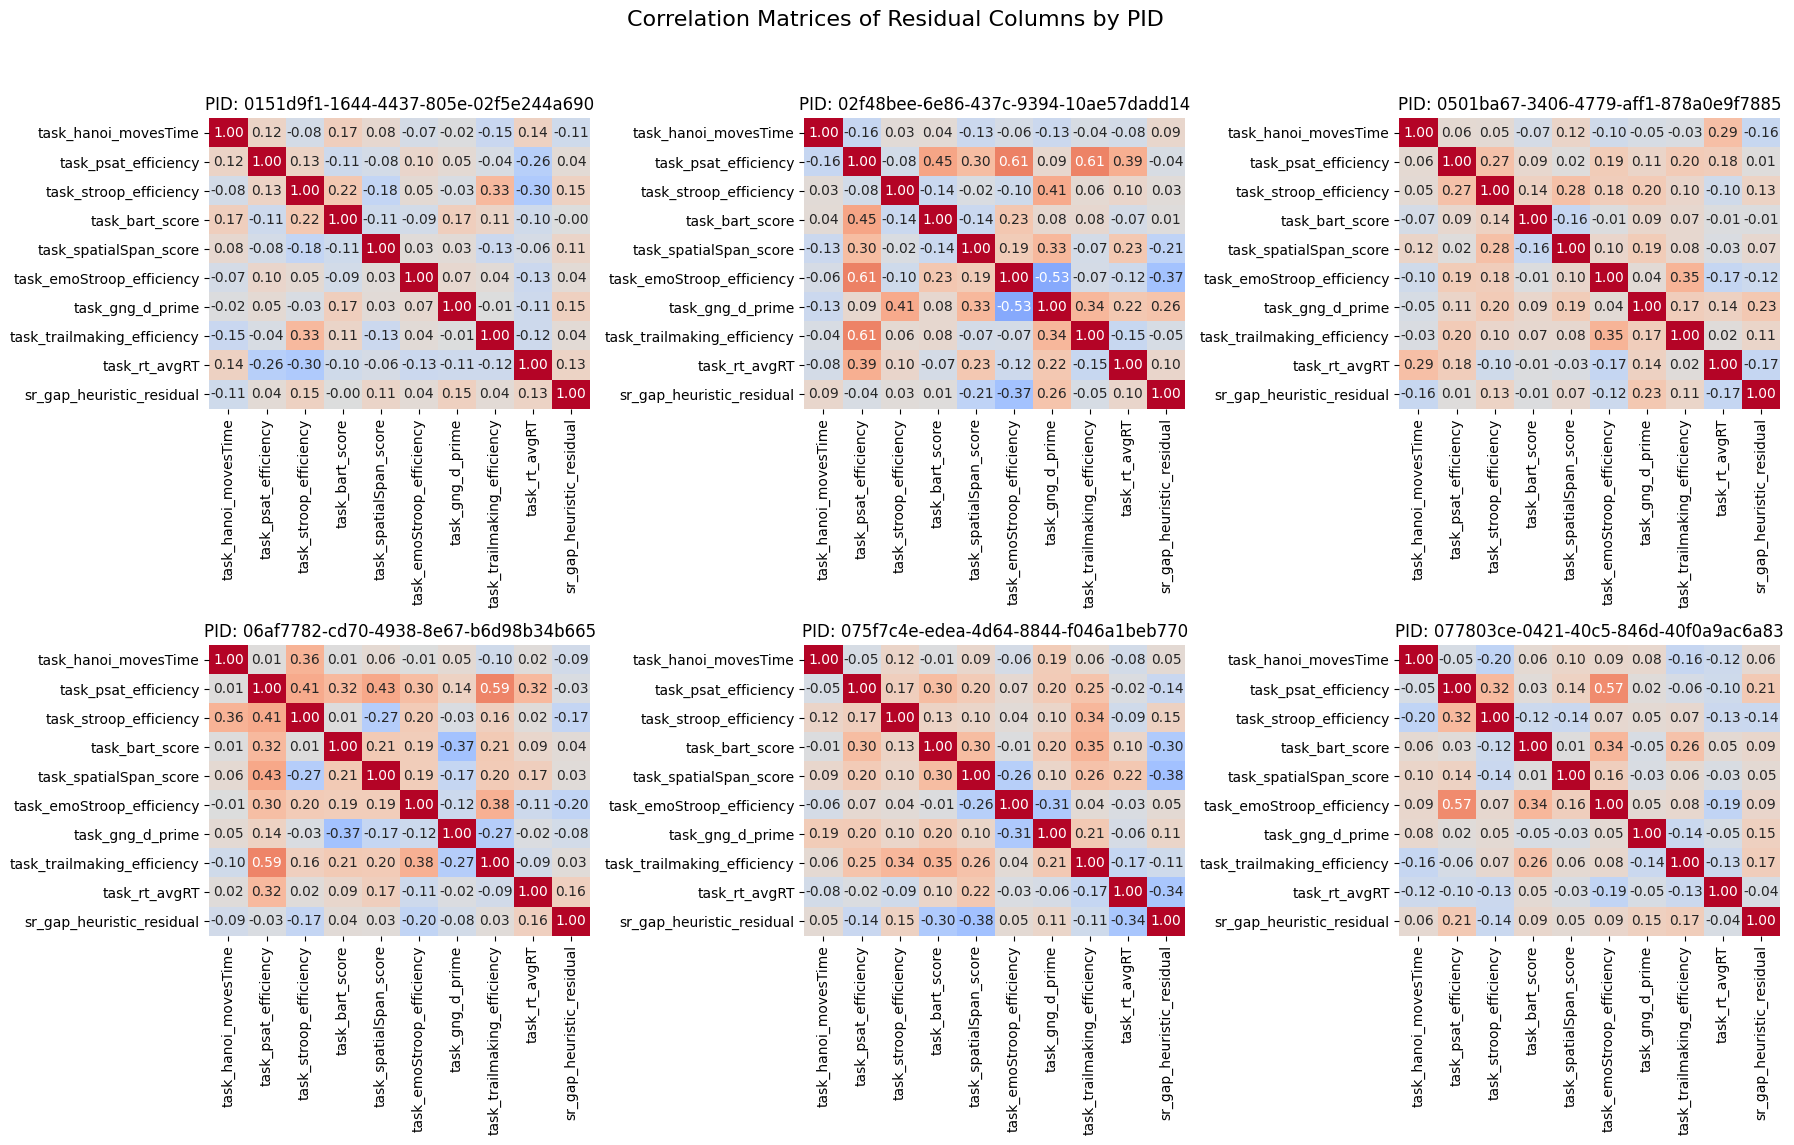

In [13]:

# Get unique PIDs
unique_pids = df['PID'].unique()

# Shorten column names by removing '_model_residual'
shortened_column_names = [col.replace('_model_residual', '') for col in residual_columns]

# Remap the original column names to the shortened names for plotting
column_name_mapping = dict(zip(residual_columns, shortened_column_names))

# Reinitialize the figure for plotting
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Correlation Matrices of Residual Columns by PID', fontsize=16)

# # Determine global min and max correlation values to standardize the color scale across all subplots
# # This ensures the color scale is consistent and 0 is accurately represented as the midpoint.
# global_min = min(pid_df.corr().min().min() for pid in unique_pids[:6])
# global_max = max(pid_df.corr().max().max() for pid in unique_pids[:6])
# vmin, vmax = min(global_min, -global_max), max(-global_min, global_max)

# Loop through the first 6 PIDs again, this time with shortened column names on the axes
for index, pid in enumerate(unique_pids[:6]):
    ax = axes[index // 3, index % 3]
    
    pid_df = df[df['PID'] == pid][residual_columns]
    # Rename columns for the current PID's dataframe for plotting
    pid_df = pid_df.rename(columns=column_name_mapping)
    correlation_matrix = pid_df.corr()
    
    # Determine global min and max correlation values to standardize the color scale across all subplots
    # This ensures the color scale is consistent and 0 is accurately represented as the midpoint.
    global_min = min(pid_df.corr().min().min() for pid in unique_pids[:6])
    global_max = max(pid_df.corr().max().max() for pid in unique_pids[:6])
    vmin, vmax = min(global_min, -global_max), max(-global_min, global_max)
    
    # Adjust 'vmin' and 'vmax' for the heatmap to center the color scale at 0
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=ax, cbar=False, center=0, vmin=vmin, vmax=vmax)
    ax.set_title(f'PID: {pid}')
    ax.tick_params(axis='x', rotation=90)
    ax.tick_params(axis='y', rotation=0)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title and x-axis labels
plt.show()

#### MLM: psat v. hanoi

In [14]:
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
from itertools import combinations

# select residual cols
residual_columns = df.columns[df.columns.str.endswith('residual')]

# Generate all unique pairs of residual columns
column_pairs = list(combinations(residual_columns, 2))

# Example pair of variables
dependent_var, independent_var = column_pairs[0]

# Dropping rows with missing values in the selected variables and 'PID'
df_clean = df.dropna(subset=[dependent_var, independent_var, 'PID'])
df_clean = df_clean.groupby('PID').filter(lambda x: len(x) >= 20)

# Prepare the data for MixedLM
# The dependent variable
endog = df_clean[dependent_var]

# The independent variables (including an intercept)
exog = sm.add_constant(df_clean[[independent_var]])  # Add an intercept term

# Grouping variable
groups = df_clean['PID']

# Fit the mixed effects model
model = MixedLM(endog, exog, groups=groups)
result = model.fit()

# Display the summary of the regression result for this pair
result.summary()

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:            MixedLM Dependent Variable: task_hanoi_movesTime_model_residual
No. Observations: 6083    Method:             REML                               
No. Groups:       97      Scale:              1142.2019                          
Min. group size:  20      Log-Likelihood:     -30042.5782                        
Max. group size:  84      Converged:          Yes                                
Mean group size:  62.7                                                           
---------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------------------
const                                  0.049    0.433  0.114 0.909  -0.800  0.899
task_psat_efficiency_model_residual   -5.197    3.165 -1.642 0.101 -11.401  1.008
Group Var                              0.000                                     
=================================================================================

"""

#### MLM: stoop vs. hanoi

In [15]:
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
from itertools import combinations

# select residual cols
residual_columns = df.columns[df.columns.str.endswith('residual')]

# Generate all unique pairs of residual columns
column_pairs = list(combinations(residual_columns, 2))

# Example pair of variables
dependent_var, independent_var = column_pairs[1]

# Dropping rows with missing values in the selected variables and 'PID'
df_clean = df.dropna(subset=[dependent_var, independent_var, 'PID'])
df_clean = df_clean.groupby('PID').filter(lambda x: len(x) >= 20)

# Prepare the data for MixedLM
# The dependent variable
endog = df_clean[dependent_var]

# The independent variables (including an intercept)
exog = sm.add_constant(df_clean[[independent_var]])  # Add an intercept term

# Grouping variable
groups = df_clean['PID']

# Fit the mixed effects model
model = MixedLM(endog, exog, groups=groups)
result = model.fit()

# Display the summary of the regression result for this pair
result.summary()

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:            MixedLM Dependent Variable: task_hanoi_movesTime_model_residual
No. Observations: 6674    Method:             REML                               
No. Groups:       98      Scale:              1125.1888                          
Min. group size:  27      Log-Likelihood:     -32912.0889                        
Max. group size:  84      Converged:          Yes                                
Mean group size:  68.1                                                           
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
const                                  -0.087    0.411 -0.211 0.833 -0.892  0.719
task_stroop_efficiency_model_residual  -5.374    2.206 -2.437 0.015 -9.697 -1.051
Group Var                               0.017                                    
=================================================================================

"""

#### MLM: All variable pairs

In [16]:
# Initialize a list to store the results
results_list = []

# Limit the number of pairs to process for demonstration
for dependent_var, independent_var in column_pairs:  # Adjust as needed for full run
    try:
        # Dropping rows with missing values in the selected variables and 'PID', and ensure group size >= 20
        df_clean = df.dropna(subset=[dependent_var, independent_var, 'PID'])
        df_clean = df_clean.groupby('PID').filter(lambda x: len(x) >= 20)

        # Check if there are enough data points after cleaning
        if df_clean.empty or len(df_clean['PID'].unique()) < 2:
            continue

        # Prepare the data for MixedLM
        endog = df_clean[dependent_var]
        exog = sm.add_constant(df_clean[[independent_var]])  # Add an intercept term
        groups = df_clean['PID']

        # Fit the mixed effects model
        model = MixedLM(endog, exog, groups=groups)
        result = model.fit()

        # Extract model values
        intercept = result.params['const']
        relationship_coef = result.params[independent_var]
        z = result.tvalues[independent_var]
        p = result.pvalues[independent_var]
        group_var = result.cov_re.iloc[0, 0] if result.cov_re.size > 0 else None
        converged = result.converged
        
        # Save the extracted values
        results_list.append({
            'variable_1': dependent_var,
            'variable_2': independent_var,
            'intercept': intercept,
            'relationship_coef': relationship_coef,
            'z': z,
            'p': p,
            'group_var': group_var,
            'converged': converged
        })
    except Exception as e:
        # In case of any error during model fitting, print the error and skip the pair
        print(f"Error processing pair ({dependent_var}, {independent_var}): {e}")
        continue

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_list)

# Display the first few rows of the results DataFrame
results_df.head()

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/djw/Documents/pCloud_synced/Academics/

,variable_1,variable_2,intercept,relationship_coef,z,p,group_var,converged
0,task_hanoi_movesTime_model_residual,task_psat_efficiency_model_residual,0.049309,-5.196580,-1.641649,0.100663,1.181825e-07,True
1,task_hanoi_movesTime_model_residual,task_stroop_efficiency_model_residual,-0.086754,-5.373945,-2.436586,0.014827,1.723653e-02,True
2,task_hanoi_movesTime_model_residual,task_bart_score_model_residual,-0.022747,0.002758,0.725254,0.468296,1.288281e-04,False
3,task_hanoi_movesTime_model_residual,task_spatialSpan_score_model_residual,-0.035760,0.002579,0.490838,0.623541,2.198893e-03,True
4,task_hanoi_movesTime_model_residual,task_emoStroop_efficiency_model_residual,-0.376161,-6.193439,-1.224121,0.220907,1.178200e-05,True


#### Plot

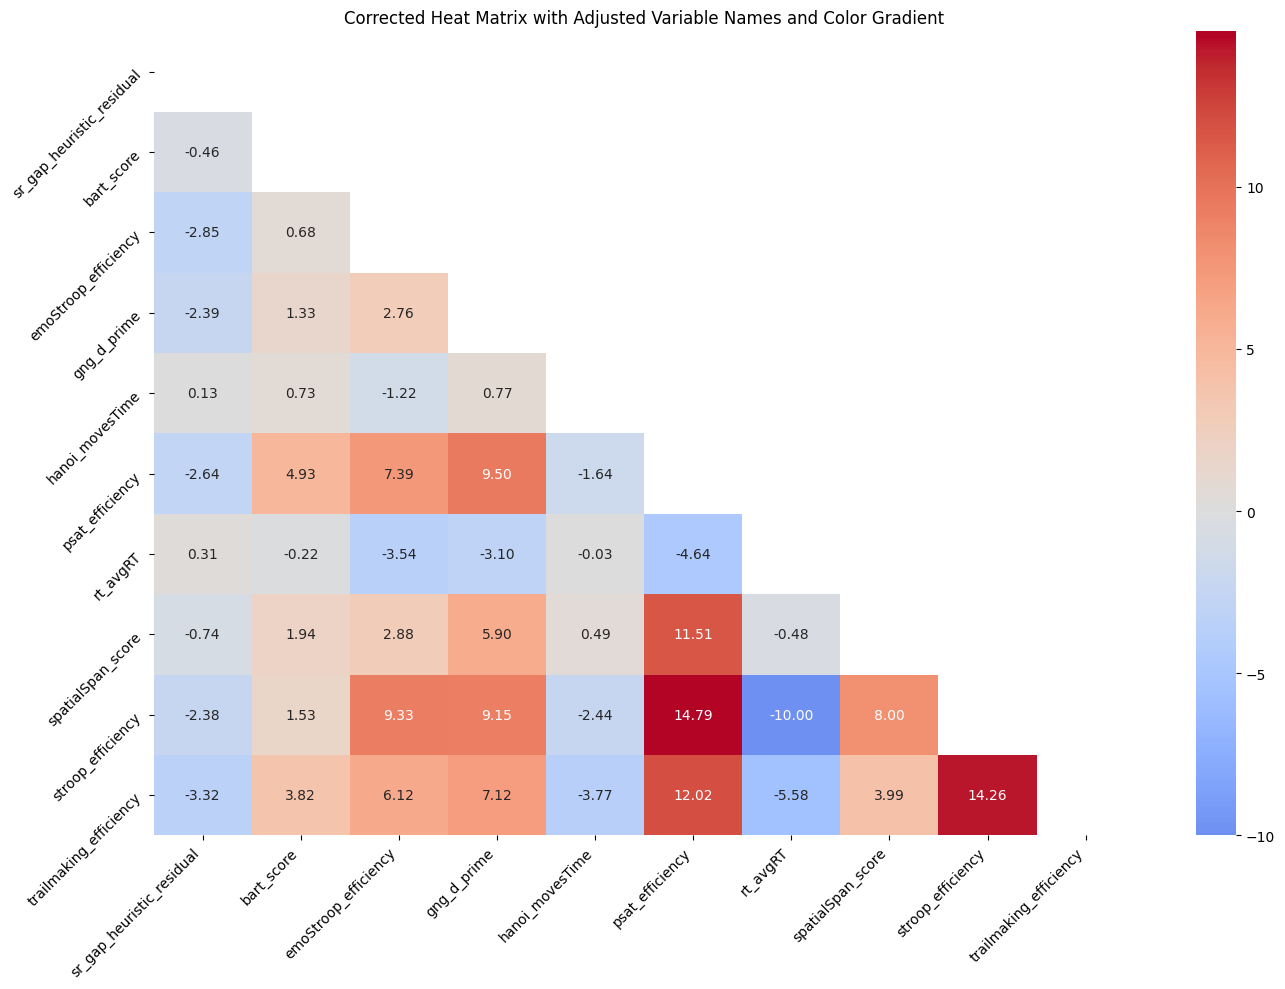

In [17]:
# Adjust the approach to ensure all values are correctly placed below the diagonal

# Creating a new DataFrame with all possible combinations of variables as both rows and columns
all_variables = sorted(np.union1d(results_df.variable_1.unique(), results_df.variable_2.unique()))
matrix_df = pd.DataFrame(index=all_variables, columns=all_variables)

# Populate the DataFrame with z values, ensuring comparisons are made below the diagonal
for i, var1 in enumerate(all_variables):
    for j, var2 in enumerate(all_variables):
        if i > j:  # Ensure we're below the diagonal
            z_value = results_df.loc[(results_df['variable_1'] == var1) & (results_df['variable_2'] == var2), 'z']
            if not z_value.empty:
                matrix_df.at[var1, var2] = z_value.values[0]
            else:
                # Look for the reverse comparison if the direct one is missing
                z_value = results_df.loc[(results_df['variable_1'] == var2) & (results_df['variable_2'] == var1), 'z']
                if not z_value.empty:
                    matrix_df.at[var1, var2] = z_value.values[0]

# Convert matrix to numeric, as it's filled with strings and NaNs
matrix_df = matrix_df.apply(pd.to_numeric)

# Remove 'task_' prefix and '_model_residual' suffix from the column names in the matrix
matrix_df_cleaned_columns = matrix_df.rename(columns=lambda x: x.replace('task_', '').replace('_model_residual', ''),
                                             index=lambda x: x.replace('task_', '').replace('_model_residual', ''))

# Adjusting the color gradient to center at 0
plt.figure(figsize=(14, 10))
sns.heatmap(matrix_df_cleaned_columns, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, center=0, mask=matrix_df_cleaned_columns.isnull())
plt.title("Corrected Heat Matrix with Adjusted Variable Names and Color Gradient")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45)
plt.tight_layout()

plt.show()


## Cognitive State Score

- First normalize the scores for each task within participant, so the row means should be zero

### Calculate CSS

In [14]:
# normalize data by pid
# Step 1: Identify all columns that contain the string 'residual'
residual_columns = [col for col in df.columns if 'residual' in col]

# Step 2: Normalize the data within each PID group for these columns
# We'll use the groupby() function along with transform() to apply the normalization within each group
for col in residual_columns:
    # Creating a z-score normalization function
    df[col + '_norm'] = df.groupby('PID')[col].transform(lambda x: (x - x.mean()) / x.std())

# Checking the first few rows to verify the new columns are added correctly
df[[col for col in df.columns if 'norm' in col]].head()

,task_hanoi_movesTime_model_residual_norm,task_psat_efficiency_model_residual_norm,task_stroop_efficiency_model_residual_norm,task_bart_score_model_residual_norm,task_spatialSpan_score_model_residual_norm,task_emoStroop_efficiency_model_residual_norm,task_gng_d_prime_model_residual_norm,task_trailmaking_efficiency_model_residual_norm,task_rt_avgRT_model_residual_norm
0,-3.127753,-3.089635,-1.083495,0.155781,-2.634315,-0.621182,-0.027458,-0.354007,0.494088
1,6.935181,-0.177976,-0.695799,1.534680,0.048476,-0.685133,-0.043766,-1.336779,1.220479
2,-1.987714,-1.144035,0.349654,0.343858,0.935917,-0.246643,1.462793,0.683783,-0.668879
3,-1.792486,-0.605352,0.533362,-0.231678,0.925682,-0.310506,-0.594748,0.560592,0.013225
4,-0.874386,-0.045704,0.938984,-0.481475,0.915448,-0.345139,2.549221,-0.656351,-0.167129


In [18]:
# normed scores for a given task for a given subject sum to 0
df.loc[df.PID == '0151d9f1-1644-4437-805e-02f5e244a690', ['task_psat_efficiency_model_residual_norm', 'task_hanoi_movesTime_model_residual_norm']].sum()

task_psat_efficiency_model_residual_norm    6.661338e-16
task_hanoi_movesTime_model_residual_norm   -1.720846e-15
dtype: float64

In [37]:
[col for col in df.columns if '_norm' in col]

['task_hanoi_movesTime_model_residual_norm',
 'task_psat_efficiency_model_residual_norm',
 'task_stroop_efficiency_model_residual_norm',
 'task_bart_score_model_residual_norm',
 'task_spatialSpan_score_model_residual_norm',
 'task_emoStroop_efficiency_model_residual_norm',
 'task_gng_d_prime_model_residual_norm',
 'task_trailmaking_efficiency_model_residual_norm',
 'task_rt_avgRT_model_residual_norm']

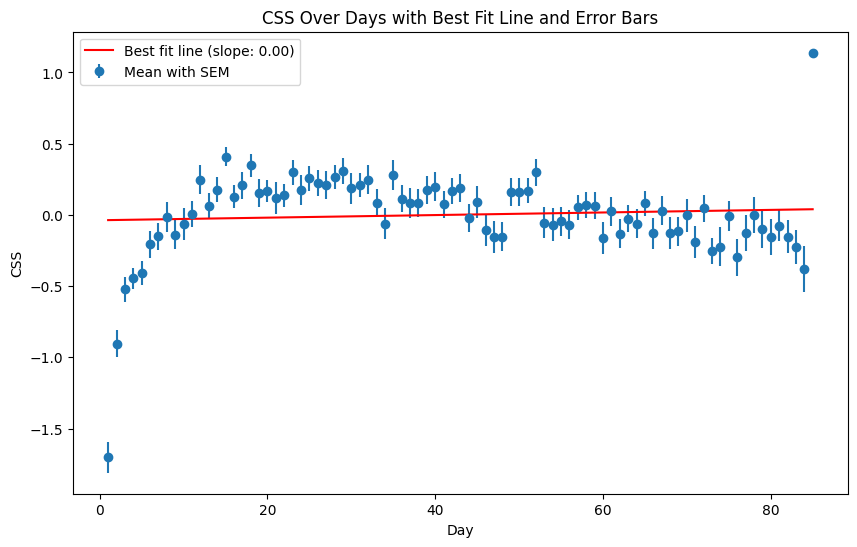

In [39]:
from scipy.stats import linregress

# Group by 'day' and calculate mean and standard deviation
grouped_df = df.groupby('day')['task_stroop_efficiency_model_residual_norm'].agg(['mean', 'std', 'count'])
grouped_df['sem'] = grouped_df['std'] / np.sqrt(grouped_df['count'])  # Standard error of the mean

# Fit a line using linear regression
slope, intercept, r_value, p_value, std_err = linregress(grouped_df.index, grouped_df['mean'])

# Calculate the best fit line
best_fit_line = slope * grouped_df.index + intercept

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(grouped_df.index, grouped_df['mean'], yerr=grouped_df['sem'], fmt='o', label='Mean with SEM')
plt.plot(grouped_df.index, best_fit_line, 'r-', label=f'Best fit line (slope: {slope:.2f})')

plt.xlabel('Day')
plt.ylabel('Stroop Efficiency')
plt.title('Stroop Efficiency Over Days with Best Fit Line and Error Bars')
plt.legend()
plt.show()

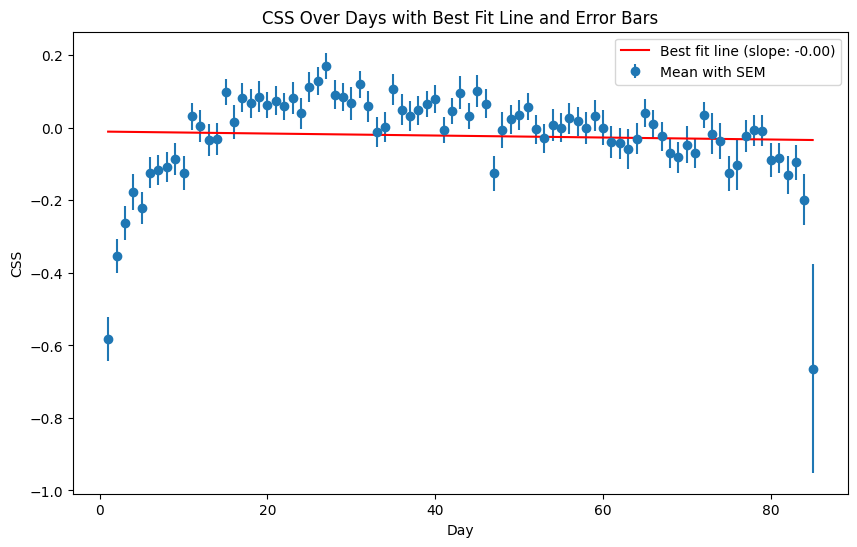

In [30]:
from scipy.stats import linregress

# Group by 'day' and calculate mean and standard deviation
grouped_df = df.groupby('day')['css'].agg(['mean', 'std', 'count'])
grouped_df['sem'] = grouped_df['std'] / np.sqrt(grouped_df['count'])  # Standard error of the mean

# Fit a line using linear regression
slope, intercept, r_value, p_value, std_err = linregress(grouped_df.index, grouped_df['mean'])

# Calculate the best fit line
best_fit_line = slope * grouped_df.index + intercept

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(grouped_df.index, grouped_df['mean'], yerr=grouped_df['sem'], fmt='o', label='Mean with SEM')
plt.plot(grouped_df.index, best_fit_line, 'r-', label=f'Best fit line (slope: {slope:.2f})')

plt.xlabel('Day')
plt.ylabel('CSS')
plt.title('CSS Over Days with Best Fit Line and Error Bars')
plt.legend()
plt.show()

In [16]:
# Identify all normalized residual columns
normalized_residual_columns = [col for col in df.columns if col.endswith('_norm')]

# Invert the sign of the score for the rt and hanoi columns
for col in normalized_residual_columns:
    if 'rt' in col or 'hanoi' in col:
        df[col] = -df[col]

# Calculate the mean of all normalized residual columns, ignoring NaN values in the mean calculation
# This mean will be stored in a new column named 'mean_residual_norm_inverted'
df['css'] = df[normalized_residual_columns].mean(axis=1, skipna=True)

# Check the first few rows to verify the new column is added correctly
df[['css']].head()

,css
0,-0.592468
1,-1.397924
2,0.483800
3,0.279997
4,0.542161


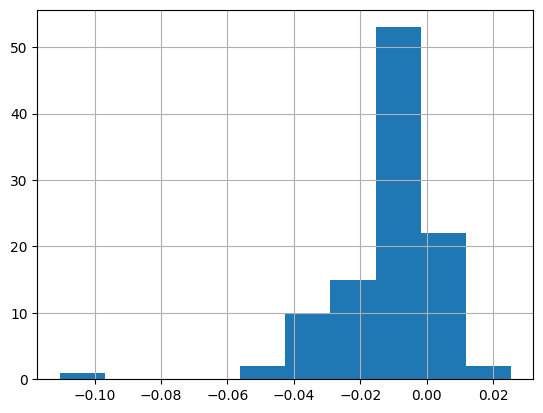

In [17]:
# Get average CSS for each subject
df.groupby('PID')['css'].mean().hist();

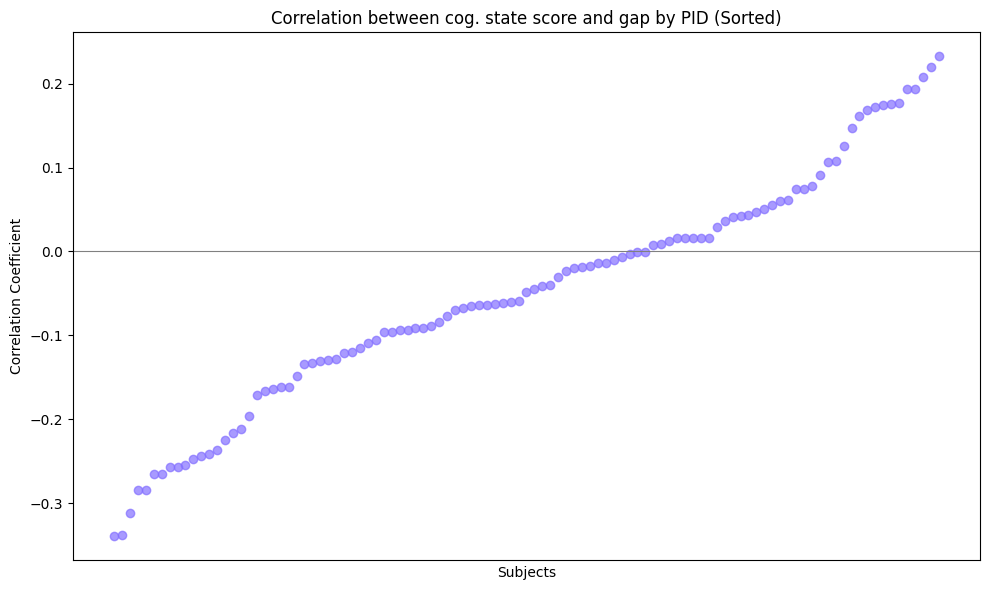

In [18]:
# Recalculate Pearson correlation coefficient for each PID
pid_correlations = df.groupby('PID').apply(
    lambda x: x['css'].corr(x['sr_gap_heuristic']))
pid_correlations_df = pid_correlations.reset_index(name='Correlation')

# Sorting correlations from smallest to largest
pid_correlations_df_sorted_asc = pid_correlations_df.sort_values(by='Correlation')

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(pid_correlations_df_sorted_asc)), pid_correlations_df_sorted_asc['Correlation'], color='#836FFF', alpha=0.7)
plt.axhline(0, color='grey', lw=0.8)  # Add a horizontal line at correlation=0 for reference
plt.xticks([])  # Remove PID labels from the x-axis
plt.ylabel('Correlation Coefficient')
plt.xlabel('Subjects')
plt.title('Correlation between cog. state score and gap by PID (Sorted)')
plt.tight_layout()  # Adjust layout to not cut off labels

plt.show()

### Does CSS Correlate with IB Gap?

In [19]:
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM

# Intercept only

# Ensure the 'sr_gap_heuristic' column exists and prepare the data for MixedLM
if 'sr_gap_heuristic' in df.columns:
    # Dropping rows with missing values in the predictor or the outcome variable
    df_mixed_effect = df.dropna(subset=['sr_gap_heuristic', 'css', 'PID'])

    # The dependent variable
    endog = df_mixed_effect['sr_gap_heuristic']

    # The independent variables (including an intercept)
    exog = sm.add_constant(df_mixed_effect[['css']])  # Add an intercept term

    # Grouping variable
    groups = df_mixed_effect['PID']

    # Fit the mixed effects model
    model = MixedLM(endog, exog, groups=groups)
    mixed_lm_result = model.fit()

    # Display the summary of the regression result again
    mixed_lm_summary = mixed_lm_result.summary()
else:
    mixed_lm_summary = "The 'sr_gap_heuristic' column does not exist in the dataframe."

mixed_lm_summary


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: sr_gap_heuristic
No. Observations: 7868    Method:             REML            
No. Groups:       105     Scale:              277.7520        
Min. group size:  43      Log-Likelihood:     -33486.3249     
Max. group size:  84      Converged:          Yes             
Mean group size:  74.9                                        
---------------------------------------------------------------
                Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------------
const           42.191     1.139  37.033  0.000  39.958  44.424
css             -1.715     0.435  -3.941  0.000  -2.568  -0.862
Group Var      132.495     1.140                               
==============================================================

"""

In [20]:
# Intercept and slope vary

import statsmodels.api as sm
import statsmodels.formula.api as smf

if 'sr_gap_heuristic' in df.columns:
    # Dropping rows with missing values in the predictor or the outcome variable
    df_mixed_effect = df.dropna(subset=['sr_gap_heuristic', 'css', 'PID'])
    
    # Define the model formula including both fixed and random effects
    formula = 'sr_gap_heuristic ~ css'
    
    # Define the random effects structure formula
    re_formula = '1 + css'
    
    # Fit the mixed effects model with varying intercepts and slopes using from_formula
    model = smf.mixedlm(formula, df_mixed_effect, groups=df_mixed_effect['PID'], re_formula=re_formula)
    mixed_lm_result = model.fit()

    # Display the summary of the regression result
    mixed_lm_summary = mixed_lm_result.summary()
else:
    mixed_lm_summary = "The 'sr_gap_heuristic' column does not exist in the dataframe."

mixed_lm_summary


<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
==============================================================
Model:            MixedLM Dependent Variable: sr_gap_heuristic
No. Observations: 7868    Method:             REML            
No. Groups:       105     Scale:              276.5462        
Min. group size:  43      Log-Likelihood:     -33479.8803     
Max. group size:  84      Converged:          Yes             
Mean group size:  74.9                                        
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           42.194    1.141 36.985 0.000 39.958 44.430
css                 -1.749    0.503 -3.481 0.001 -2.735 -0.764
Group Var          132.888    1.146                           
Group x css Cov     16.556    0.368                           
css Var              6.421    0.214                           
==============================================================

"""

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_2255/3507114662.py:44: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Slope Value')


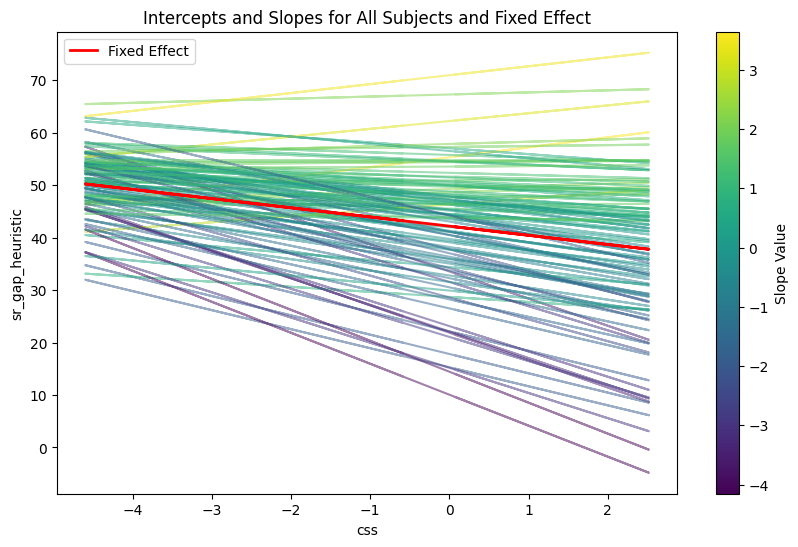

In [21]:
# Prepare figure for plotting
plt.figure(figsize=(10, 6))

# Extract random effects
random_effects = mixed_lm_result.random_effects

# Extract the fixed effects intercept and slope
fixed_intercept = mixed_lm_result.params['Intercept']
fixed_slope = mixed_lm_result.params['css']

# Determine the range of slope values
slope_values = [effects[1] for effects in random_effects.values()]
min_slope, max_slope = min(slope_values), max(slope_values)

# Choose a colormap
colormap = plt.cm.viridis

# Normalize the slope values to [0, 1] for the colormap
normalize = plt.Normalize(vmin=min_slope, vmax=max_slope)

# Plotting each subject's intercept and slope with color based on slope
for pid, effects in random_effects.items():
    intercept = effects[0]  # Extract intercept for the subject
    slope = effects[1]      # Extract slope for the subject
    color = colormap(normalize(slope))  # Map slope to color
    # Plot line for each subject
    plt.plot(df_mixed_effect['css'].unique(), 
             (intercept + fixed_intercept) + (slope + fixed_slope) * df_mixed_effect['css'].unique(),
             color=color, alpha=0.5, zorder=1)

# Plot line for fixed effects
plt.plot(df_mixed_effect['css'].unique(), 
         fixed_intercept + fixed_slope * df_mixed_effect['css'].unique(), 
         color='red', linewidth=2, label='Fixed Effect', zorder=2)

# Enhancing the plot
plt.xlabel('css')
plt.ylabel('sr_gap_heuristic')
plt.title('Intercepts and Slopes for All Subjects and Fixed Effect')

# Add colorbar to indicate the mapping of slope values to colors
sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
sm.set_array([])
plt.colorbar(sm, label='Slope Value')

plt.legend()

plt.show()

### Does CSS Correlate with Detrended Gap?

Model gap and calculate gap residuals

##### Detrend Gap

In [22]:
# Intercept and slope vary

import statsmodels.api as sm
import statsmodels.formula.api as smf

if 'sr_gap_heuristic' in df.columns:
    # Dropping rows with missing values in the predictor or the outcome variable
    df_mixed_effect = df.dropna(subset=['sr_gap_heuristic', 'day', 'PID'])
    
    # Define the model formula including both fixed and random effects
    formula = 'sr_gap_heuristic ~ day'
    
    # Define the random effects structure formula
    re_formula = '1 + day'
    
    # Fit the mixed effects model with varying intercepts and slopes using from_formula
    model = smf.mixedlm(formula, df_mixed_effect, groups=df_mixed_effect['PID'], re_formula=re_formula)
    mixed_lm_result = model.fit()

    # Display the summary of the regression result
    mixed_lm_summary = mixed_lm_result.summary()
else:
    mixed_lm_summary = "The 'sr_gap_heuristic' column does not exist in the dataframe."

print(mixed_lm_summary)


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: sr_gap_heuristic
No. Observations: 8068    Method:             REML            
No. Groups:       105     Scale:              271.6683        
Min. group size:  45      Log-Likelihood:     -34329.1078     
Max. group size:  84      Converged:          Yes             
Mean group size:  76.8                                        
--------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept           44.415    1.197 37.102 0.000 42.068 46.761
day                 -0.053    0.017 -3.048 0.002 -0.086 -0.019
Group Var          135.802    1.276                           
Group x day Cov     -0.506    0.014                           
day Var              0.024    0.000                           



/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_2255/4013542759.py:44: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Slope Value')


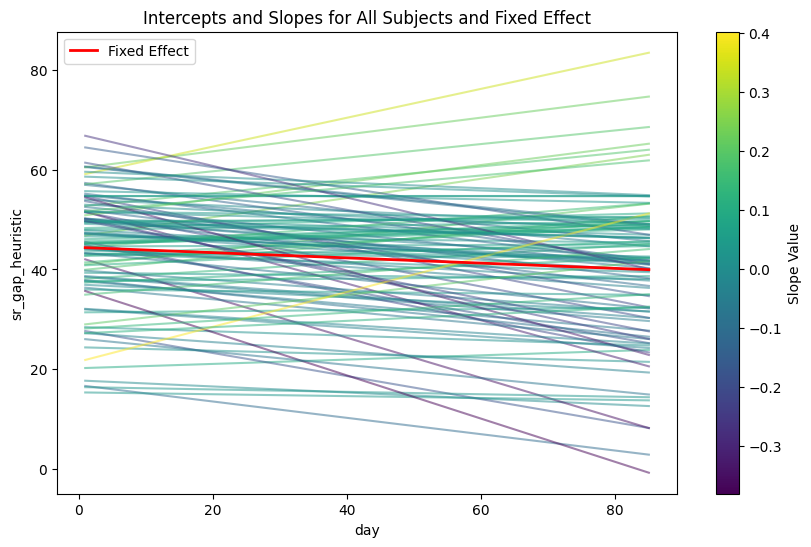

In [23]:
# Prepare figure for plotting
plt.figure(figsize=(10, 6))

# Extract random effects
random_effects = mixed_lm_result.random_effects

# Extract the fixed effects intercept and slope
fixed_intercept = mixed_lm_result.params['Intercept']
fixed_slope = mixed_lm_result.params['day']

# Determine the range of slope values
slope_values = [effects[1] for effects in random_effects.values()]
min_slope, max_slope = min(slope_values), max(slope_values)

# Choose a colormap
colormap = plt.cm.viridis

# Normalize the slope values to [0, 1] for the colormap
normalize = plt.Normalize(vmin=min_slope, vmax=max_slope)

# Plotting each subject's intercept and slope with color based on slope
for pid, effects in random_effects.items():
    intercept = effects[0]  # Extract intercept for the subject
    slope = effects[1]      # Extract slope for the subject
    color = colormap(normalize(slope))  # Map slope to color
    # Plot line for each subject
    plt.plot(df_mixed_effect['day'].unique(), 
             (intercept + fixed_intercept) + (slope + fixed_slope) * df_mixed_effect['day'].unique(),
             color=color, alpha=0.5, zorder=1)

# Plot line for fixed effects
plt.plot(df_mixed_effect['day'].unique(), 
         fixed_intercept + fixed_slope * df_mixed_effect['day'].unique(), 
         color='red', linewidth=2, label='Fixed Effect', zorder=2)

# Enhancing the plot
plt.xlabel('day')
plt.ylabel('sr_gap_heuristic')
plt.title('Intercepts and Slopes for All Subjects and Fixed Effect')

# Add colorbar to indicate the mapping of slope values to colors
sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
sm.set_array([])
plt.colorbar(sm, label='Slope Value')

plt.legend()

plt.show()

In [24]:
# Calculate residuals for each observation
df['sr_gap_heuristic_residual'] = mixed_lm_result.resid

# Extract random effects for each subject
random_effects = mixed_lm_result.random_effects

# Extract the fixed effects intercept and slope
fixed_intercept = mixed_lm_result.params['Intercept']
fixed_slope = mixed_lm_result.params['day']

# Initialize columns for intercept and slope
df['sr_gap_heuristic_intercept'] = 0
df['sr_gap_heuristic_slope'] = 0

# Assign the random intercepts and slopes to each subject
for pid, effects in random_effects.items():
    df.loc[df['PID'] == pid, 'sr_gap_heuristic_intercept'] = effects[0] + fixed_intercept
    df.loc[df['PID'] == pid, 'sr_gap_heuristic_slope'] = effects[1] + fixed_slope

# Check the first few rows to verify the new columns
df[['PID', 'day', 'sr_gap_heuristic', 'sr_gap_heuristic_residual', 'sr_gap_heuristic_intercept', 'sr_gap_heuristic_slope']].head()

,PID,day,sr_gap_heuristic,sr_gap_heuristic_residual,sr_gap_heuristic_intercept,sr_gap_heuristic_slope
0,0151d9f1-1644-4437-805e-02f5e244a690,1,5.00,-12.693303,17.753776,-0.060473
1,0151d9f1-1644-4437-805e-02f5e244a690,2,15.25,-2.382829,17.753776,-0.060473
2,0151d9f1-1644-4437-805e-02f5e244a690,3,46.35,28.777644,17.753776,-0.060473
3,0151d9f1-1644-4437-805e-02f5e244a690,4,43.70,26.188117,17.753776,-0.060473
4,0151d9f1-1644-4437-805e-02f5e244a690,5,45.60,28.148591,17.753776,-0.060473


##### Model Association

In [25]:
# Intercept and slope vary

if 'sr_gap_heuristic_residual' in df.columns:
    # Dropping rows with missing values in the predictor or the outcome variable
    df_mixed_effect = df.dropna(subset=['sr_gap_heuristic_residual', 'css', 'PID'])
    
    # Define the model formula including both fixed and random effects
    formula = 'sr_gap_heuristic_residual ~ css'
    
    # Define the random effects structure formula
    re_formula = '1 + css'
    
    # Fit the mixed effects model with varying intercepts and slopes using from_formula
    model = smf.mixedlm(formula, df_mixed_effect, groups=df_mixed_effect['PID'], re_formula=re_formula)
    mixed_lm_result = model.fit()

    # Display the summary of the regression result
    mixed_lm_summary = mixed_lm_result.summary()
else:
    mixed_lm_summary = "The 'sr_gap_heuristic_residual' column does not exist in the dataframe."

print(mixed_lm_summary)


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                 Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: sr_gap_heuristic_residual
No. Observations: 7868    Method:             REML                     
No. Groups:       105     Scale:              257.1631                 
Min. group size:  43      Log-Likelihood:     -33012.6131              
Max. group size:  84      Converged:          Yes                      
Mean group size:  74.9                                                 
-------------------------------------------------------------------------
                     Coef.    Std.Err.     z      P>|z|   [0.025   0.975]
-------------------------------------------------------------------------
Intercept            -0.089      0.181   -0.493   0.622   -0.444    0.265
css                  -1.712      0.493   -3.472   0.001   -2.679   -0.746
Group Var             0.000                                              
Group x css Cov      -0.000      0.172                               

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_2255/473136780.py:48: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Slope Value')


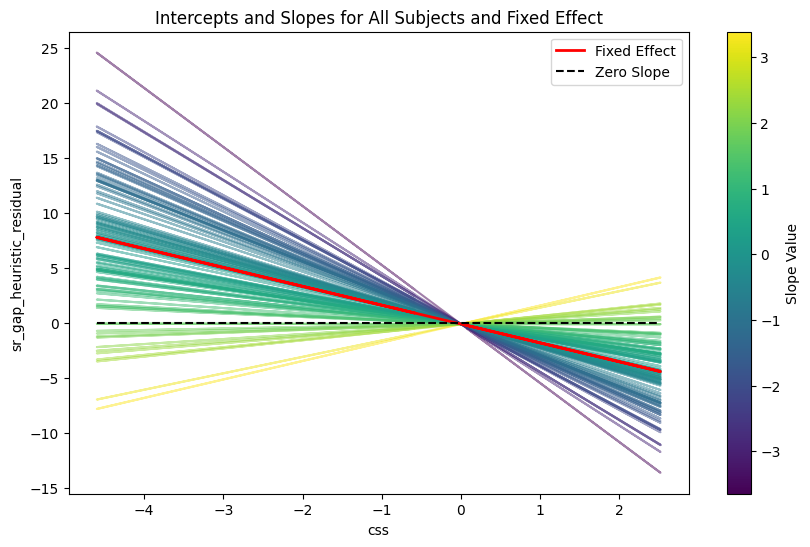

In [26]:
# Prepare figure for plotting
plt.figure(figsize=(10, 6))

# Extract random effects
random_effects = mixed_lm_result.random_effects

# Extract the fixed effects intercept and slope
fixed_intercept = mixed_lm_result.params['Intercept']
fixed_slope = mixed_lm_result.params['css']

# Determine the range of slope values
slope_values = [effects[1] for effects in random_effects.values()]
min_slope, max_slope = min(slope_values), max(slope_values)

# Choose a colormap
colormap = plt.cm.viridis

# Normalize the slope values to [0, 1] for the colormap
normalize = plt.Normalize(vmin=min_slope, vmax=max_slope)

# Plotting each subject's intercept and slope with color based on slope
for pid, effects in random_effects.items():
    intercept = effects[0]  # Extract intercept for the subject
    slope = effects[1]      # Extract slope for the subject
    color = colormap(normalize(slope))  # Map slope to color
    # Plot line for each subject
    plt.plot(df_mixed_effect['css'].unique(), 
             (intercept + fixed_intercept) + (slope + fixed_slope) * df_mixed_effect['css'].unique(),
             color=color, alpha=0.5, zorder=1)

# Plot line for fixed effects
plt.plot(df_mixed_effect['css'].unique(), 
         fixed_intercept + fixed_slope * df_mixed_effect['css'].unique(), 
         color='red', linewidth=2, label='Fixed Effect', zorder=2)

# Plot horizontal line
plt.plot([df_mixed_effect['css'].min(), df_mixed_effect['css'].max()], [0,0],
         color='black', ls= '--', label = 'Zero Slope')

# Enhancing the plot
plt.xlabel('css')
plt.ylabel('sr_gap_heuristic_residual')
plt.title('Intercepts and Slopes for All Subjects and Fixed Effect')

# Add colorbar to indicate the mapping of slope values to colors
sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
sm.set_array([])
plt.colorbar(sm, label='Slope Value')

plt.legend()

plt.show()

### Gap Slope and Grades

In [27]:
grades = pd.read_csv('../../3_3_2_processed_data/all_grades.csv')
grades = grades[['PID', 'grades_avg']]

# merge with df
df = df.merge(grades, how='left', on='PID')

In [28]:
import statsmodels.api as sm

df_onerow = df.drop_duplicates(subset = 'PID')

X1 = df_onerow['sr_gap_heuristic_slope']
X2 = df_onerow['sr_gap_heuristic_intercept']
y = df_onerow['grades_avg']

# Define and fit the model
model = smf.ols('y ~ X1 * X2', data=df_onerow).fit()


# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.5724
Date:                Tue, 05 Mar 2024   Prob (F-statistic):              0.634
Time:                        10:57:08   Log-Likelihood:                -387.35
No. Observations:                 105   AIC:                             782.7
Df Residuals:                     101   BIC:                             793.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     80.0716      4.169     19.207      0.0

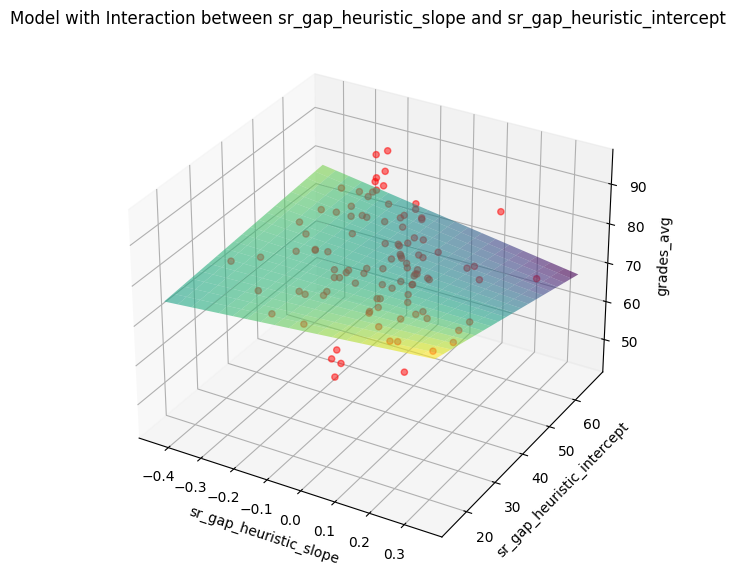

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Creating a meshgrid of values for X1 and X2
x1_range = np.linspace(df_onerow['sr_gap_heuristic_slope'].min(), df_onerow['sr_gap_heuristic_slope'].max(), 20)
x2_range = np.linspace(df_onerow['sr_gap_heuristic_intercept'].min(), df_onerow['sr_gap_heuristic_intercept'].max(), 20)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)

# Calculate predictions over the grid
y_pred = model.predict(exog=dict(X1=x1_grid.ravel(), X2=x2_grid.ravel()))
y_grid = y_pred.values.reshape(x1_grid.shape)

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(x1_grid, x2_grid, y_grid, cmap='viridis', alpha=0.6)


# Scatter plot of original data
ax.scatter(df_onerow['sr_gap_heuristic_slope'], df_onerow['sr_gap_heuristic_intercept'], df_onerow['grades_avg'], color='red', alpha=0.5)

ax.set_xlabel('sr_gap_heuristic_slope')
ax.set_ylabel('sr_gap_heuristic_intercept')
ax.set_zlabel('grades_avg')
plt.title('Model with Interaction between sr_gap_heuristic_slope and sr_gap_heuristic_intercept')
plt.show()


### CSS and Motivation

In [32]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

if 'task_motivation_level' in df.columns:
    # Dropping rows with missing values in the predictor or the outcome variable
    df_mixed_effect = df.dropna(subset=['task_motivation_level', 'css', 'PID'])
    
    # Define the model formula including both fixed and random effects
    formula = 'css ~ task_motivation_level'
    
    # Define the random effects structure formula
    re_formula = '1 + task_motivation_level'
    
    # Fit the mixed effects model with varying intercepts and slopes using from_formula
    model = smf.mixedlm(formula, df_mixed_effect, groups=df_mixed_effect['PID'], re_formula=re_formula)
    mixed_lm_result = model.fit()

    # Display the summary of the regression result
    mixed_lm_summary = mixed_lm_result.summary()
else:
    mixed_lm_summary = "The 'task_motivation_level' column does not exist in the dataframe."

mixed_lm_summary

/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/djw/Documents/pCloud_synce

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:                    MixedLM       Dependent Variable:       css       
No. Observations:         8026          Method:                   REML      
No. Groups:               105           Scale:                    0.1871    
Min. group size:          47            Log-Likelihood:           -5079.5379
Max. group size:          84            Converged:                No        
Mean group size:          76.4                                              
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         -0.043    0.017 -2.562 0.010 -0.076 -0.010
task_motivation_level              0.007    0.040  0.176 0.860 -0.071  0.085
Group Var                          0.008    0.015                           
Group x task_motivation_level Cov  0.004    0.119                           
task_motivation_level Var          0.164                                    
============================================================================

"""

### CSS and NASA

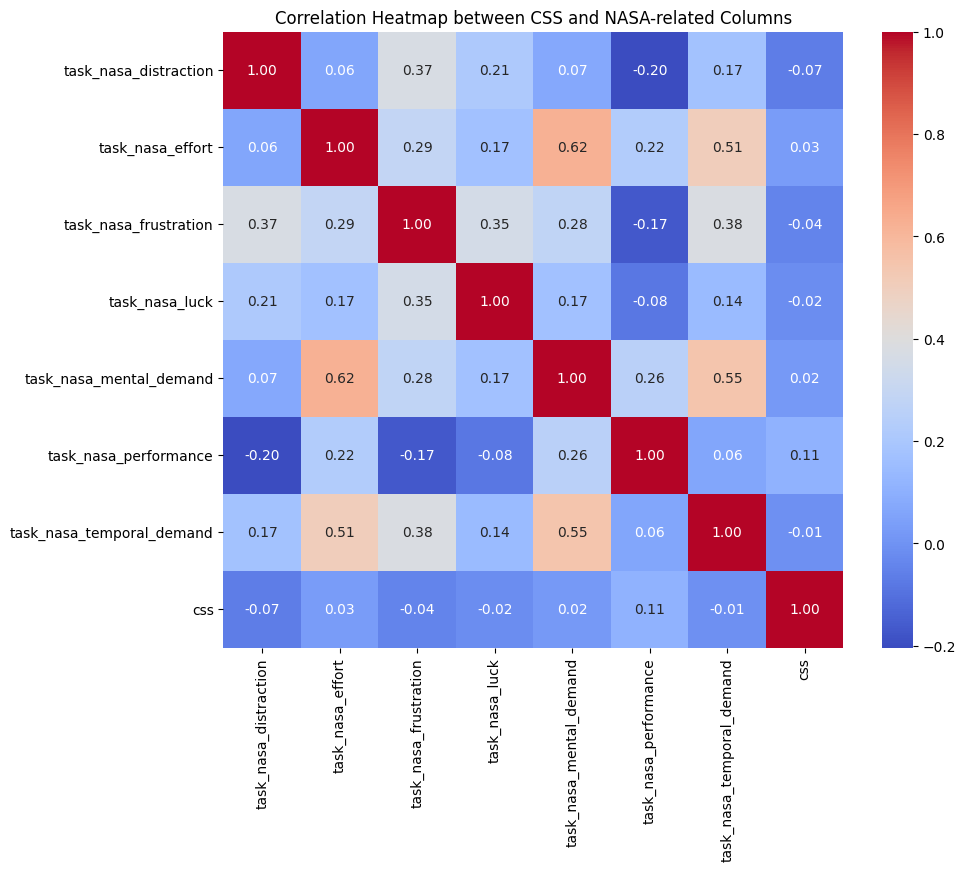

In [34]:
# Identify columns that have '_nasa' in their name and the 'css' column
columns_of_interest = [col for col in df.columns if '_nasa' in col] + ['css']

# Filter the dataframe to include only the columns of interest
df_filtered = df[columns_of_interest]

# Calculate the correlation matrix
correlation_matrix = df_filtered.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between CSS and NASA-related Columns')
plt.show()

## Raw Cog. State Score x Grades

In [184]:
# Identify task columns
raw_task_scores = ['task_hanoi_movesTime',
                   'task_psat_efficiency',
                   'task_stroop_efficiency',
                   'task_bart_score',
                   'task_spatialSpan_score',
                   'task_emoStroop_efficiency',
                   'task_gng_d_prime',
                   'task_trailmaking_efficiency',
                   'task_rt_avgRT'
]

# Normalize by task (across subjects)
for col in raw_task_scores:
    # Creating a z-score normalization function
    df[col + '_norm_col'] = df[col].transform(lambda x: (x - x.mean()) / x.std())


task_socres_norm_col = [col for col in df.columns if col.endswith('_norm_col')]

# Invert the sign of the score for the rt and hanoi columns
for col in task_socres_norm_col:
    if 'rt' in col or 'hanoi' in col:
        df[col] = -df[col]

# Calculate the mean of all task column scores, ignoring NaN values in the mean calculation
df['css_acrossSub_mean'] = df[task_socres_norm_col].mean(axis=1, skipna=True)

In [194]:
css_grades = pd.DataFrame(df.groupby('PID')['css_acrossSub_mean'].mean().reset_index()).merge(grades, how = 'left', on = 'PID')
css_grades.head()

,PID,css_acrossSub_mean,grades_avg
0,0151d9f1-1644-4437-805e-02f5e244a690,0.896637,95.00
1,02f48bee-6e86-437c-9394-10ae57dadd14,0.163449,67.50
2,0501ba67-3406-4779-aff1-878a0e9f7885,0.275544,65.25
3,06af7782-cd70-4938-8e67-b6d98b34b665,-0.185676,82.50
4,075f7c4e-edea-4d64-8844-f046a1beb770,-0.083202,68.20


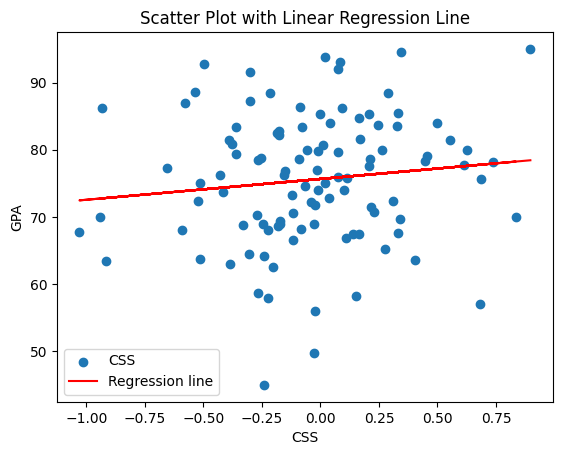

                            OLS Regression Results                            
Dep. Variable:             grades_avg   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.464
Date:                Tue, 05 Mar 2024   Prob (F-statistic):              0.229
Time:                        10:40:41   Log-Likelihood:                -387.49
No. Observations:                 105   AIC:                             779.0
Df Residuals:                     103   BIC:                             784.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 75.6519      0

In [197]:
import statsmodels.api as sm

X = css_grades['css_acrossSub_mean']
y = css_grades['grades_avg']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Scatter plot of observed data
plt.scatter(X['css_acrossSub_mean'], y, label='CSS')

# Regression line
plt.plot(X['css_acrossSub_mean'], predictions, color='red', label='Regression line')

# Labels and legend
plt.xlabel('CSS')
plt.ylabel('GPA')
plt.title('Scatter Plot with Linear Regression Line')
plt.legend()

# Display the plot
plt.show()

print(model.summary())

## IB Gap

In [52]:
residual_columns

Index(['task_hanoi_movesTime_model_residual',
       'task_psat_efficiency_model_residual',
       'task_stroop_efficiency_model_residual',
       'task_bart_score_model_residual',
       'task_spatialSpan_score_model_residual',
       'task_emoStroop_efficiency_model_residual',
       'task_gng_d_prime_model_residual',
       'task_trailmaking_efficiency_model_residual',
       'task_rt_avgRT_model_residual'],
      dtype='object')

In [57]:
select_cols = list(residual_columns) + ['sr_gap_heuristic']

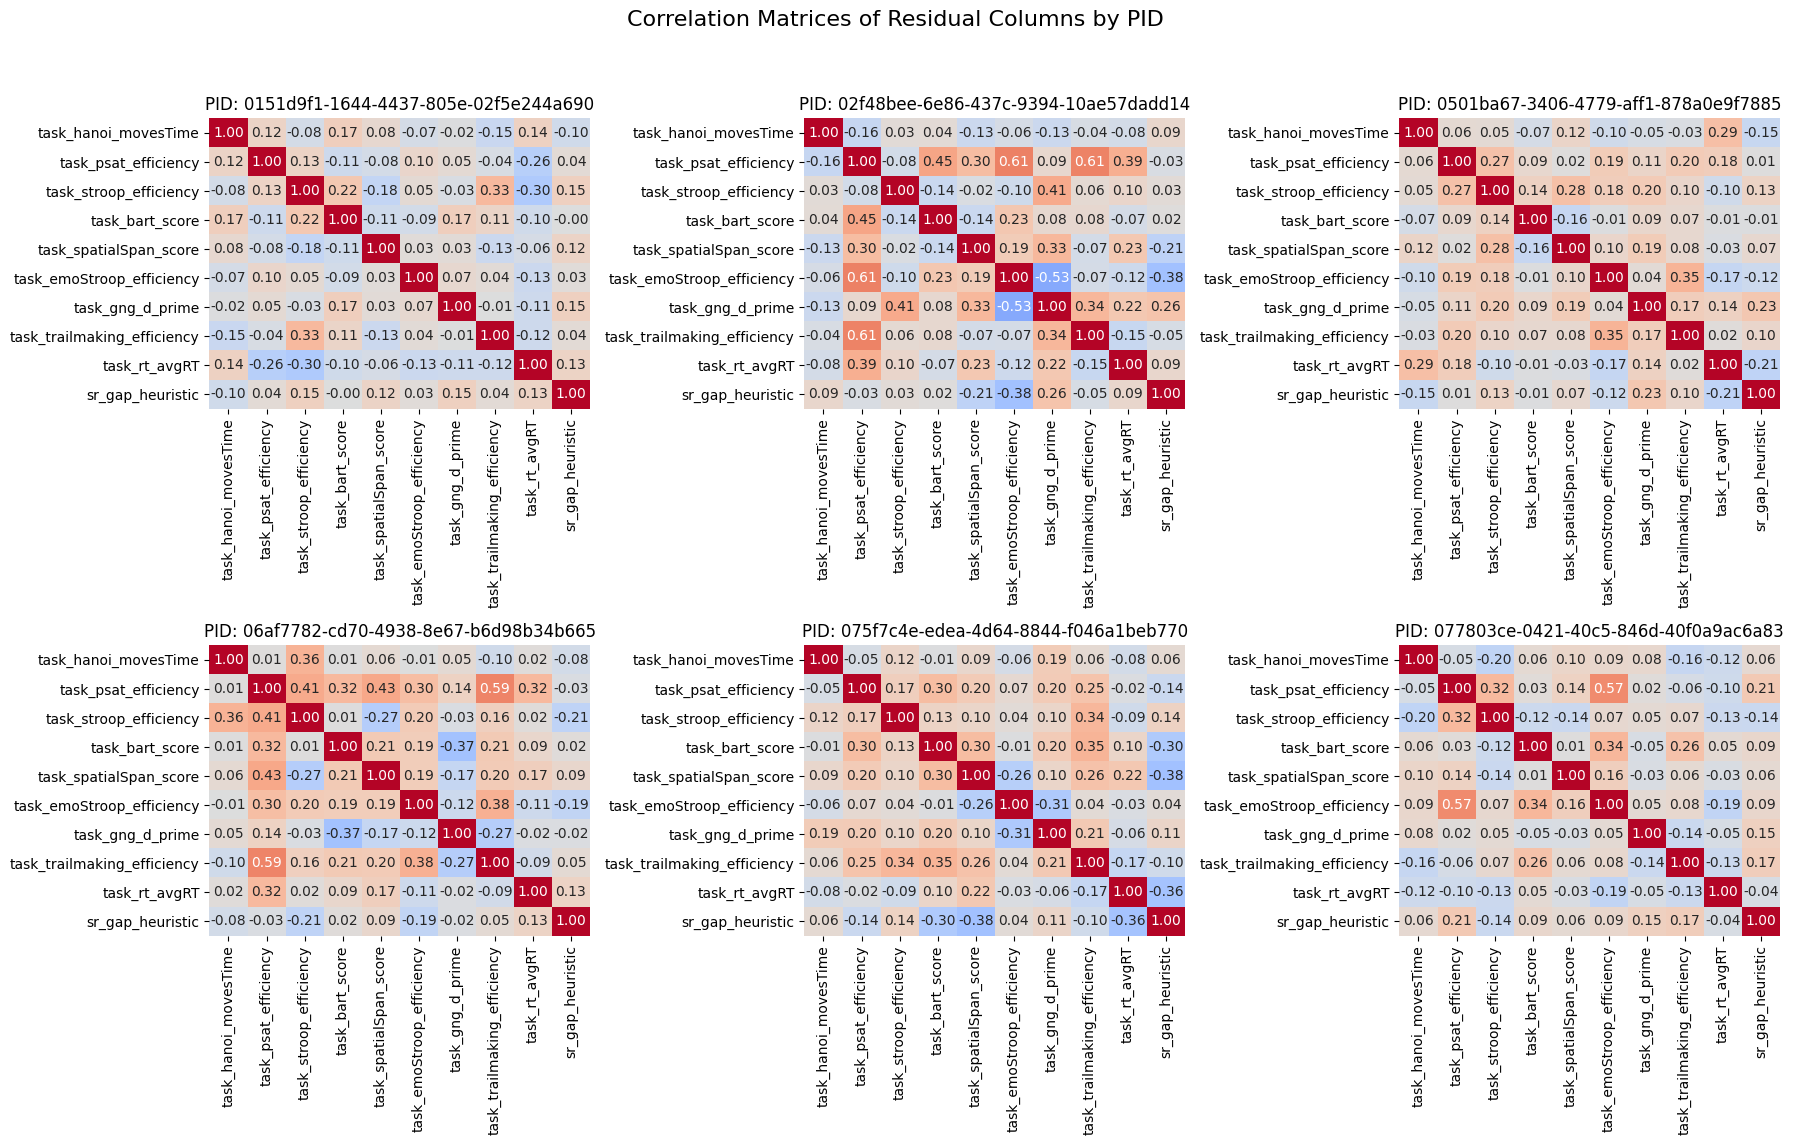

In [61]:
# Get unique PIDs
unique_pids = df['PID'].unique()

# Shorten column names by removing '_model_residual'
shortened_column_names = [col.replace('_model_residual', '') for col in select_cols]
# shortened_column_names = [col.replace('task_', '') for col in select_cols]

# Remap the original column names to the shortened names for plotting
column_name_mapping = dict(zip(select_cols, shortened_column_names))

# Reinitialize the figure for plotting
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle('Correlation Matrices of Residual Columns by PID', fontsize=16)

# Determine global min and max correlation values to standardize the color scale across all subplots
# This ensures the color scale is consistent and 0 is accurately represented as the midpoint.
global_min = min(pid_df.corr().min().min() for pid in unique_pids[:6])
global_max = max(pid_df.corr().max().max() for pid in unique_pids[:6])
vmin, vmax = min(global_min, -global_max), max(-global_min, global_max)

# Loop through the first 6 PIDs again, this time with shortened column names on the axes
for index, pid in enumerate(unique_pids[:6]):
    ax = axes[index // 3, index % 3]
    
    pid_df = df[df['PID'] == pid][select_cols]
    # Rename columns for the current PID's dataframe for plotting
    pid_df = pid_df.rename(columns=column_name_mapping)
    correlation_matrix = pid_df.corr()
    
    # Adjust 'vmin' and 'vmax' for the heatmap to center the color scale at 0
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", ax=ax, cbar=False, center=0, vmin=vmin, vmax=vmax)
    ax.set_title(f'PID: {pid}')
    ax.tick_params(axis='x', rotation=90)
    ax.tick_params(axis='y', rotation=0)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title and x-axis labels
plt.show()